In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.config import processed_data_dir

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Analysis

In [2]:
data_df = pd.read_json(processed_data_dir / "products_reviews.json.gz")

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")
data_df["brand"] = data_df["brand"].astype("category")
data_df["category"] = data_df["category"].astype("category")
data_df["description"] = data_df["description"].astype("string")
data_df["title"] = data_df["title"].astype("string")

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183777 entries, 0 to 183776
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   asin             183777 non-null  category      
 1   overall          183777 non-null  category      
 2   summary          183777 non-null  string        
 3   text             183777 non-null  string        
 4   timestamp        183777 non-null  datetime64[ns]
 5   vote             183777 non-null  int64         
 6   brand            183777 non-null  category      
 7   category         183777 non-null  category      
 8   description      178347 non-null  string        
 9   imageURLHighRes  151801 non-null  object        
 10  title            183777 non-null  string        
dtypes: category(4), datetime64[ns](1), int64(1), object(1), string(4)
memory usage: 12.6+ MB


# ASIN

Mean number of reviews: 28.203959484346225


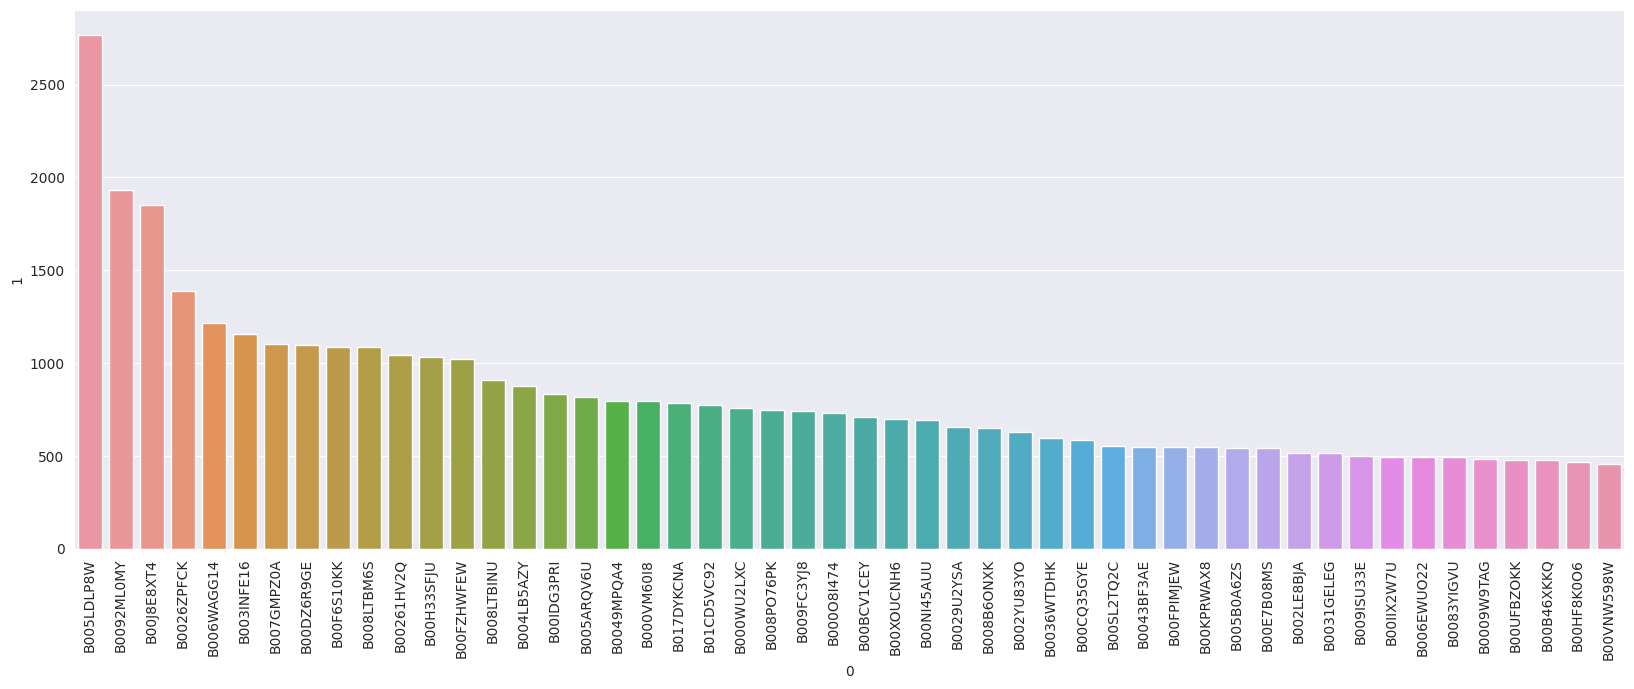

In [3]:
# number of reviews per product (ASIN)
data = pd.DataFrame(Counter(data_df["asin"].tolist()).most_common(50))
_, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=90)
sns.barplot(x=data[0], y=data[1], ax=ax)

# average number of reviews
z = pd.DataFrame(data_df["asin"].value_counts())
print("Mean number of reviews:", z["asin"].mean())

# Title

In [4]:
# most reviewed titles
c = Counter(data_df["title"].astype("string")).most_common(10)
pd.DataFrame(c, columns=["title", "frequency"])

,title,frequency
0,Crucial 2GB Single DDR3/DDR3L 1600 MT/S (PC3-1...,2765
1,Corsair CX Series 500 Watt 80 Plus Bronze Cert...,1934
2,Kingston HyperX FURY 16GB Kit (2x8GB) 1600MHz ...,1852
3,Cooler Master SickleFlow 120 - Sleeve Bearing ...,1389
4,Ballistix Sport 4GB Single DDR3 1600 MT/s (PC3...,1216
5,Cooler Master Vortex Plus - CPU Cooler with Al...,1155
6,TP-Link TL-WDN4800 N900 Dual Band PCI-E Wirele...,1104
7,"EVGA 500 B1, 80+ BRONZE 500W Power Supply, 3 Y...",1098
8,Corsair Air Series AF120 LED Quiet Edition Hig...,1088
9,Crucial 4GB Single DDR3/DDR3L 1600 MT/s (PC3-1...,1085


# Brand & Category

### Most Reviewed Brand

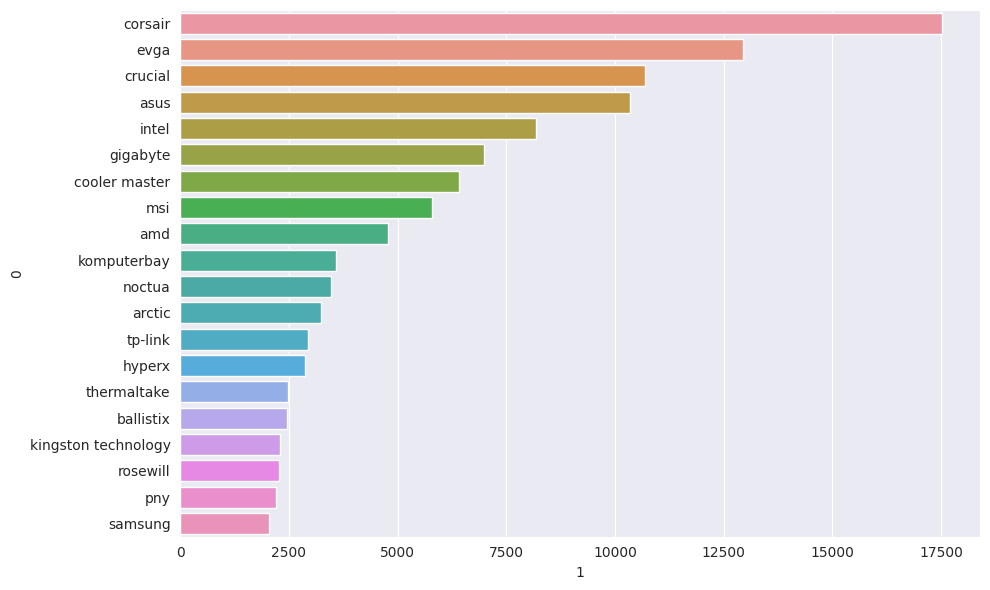

In [5]:
data = pd.DataFrame(Counter(data_df["brand"].tolist()).most_common(20))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=data[0], x=data[1], ax=ax)
fig.tight_layout()

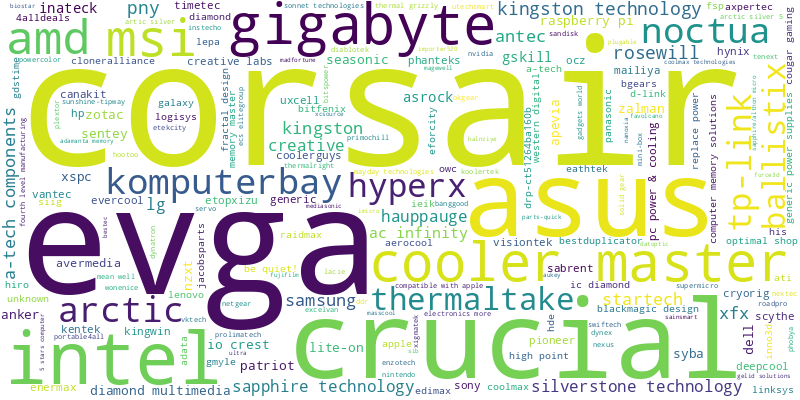

In [6]:
c = Counter(list(data_df["brand"]))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Most Reviewed Categories

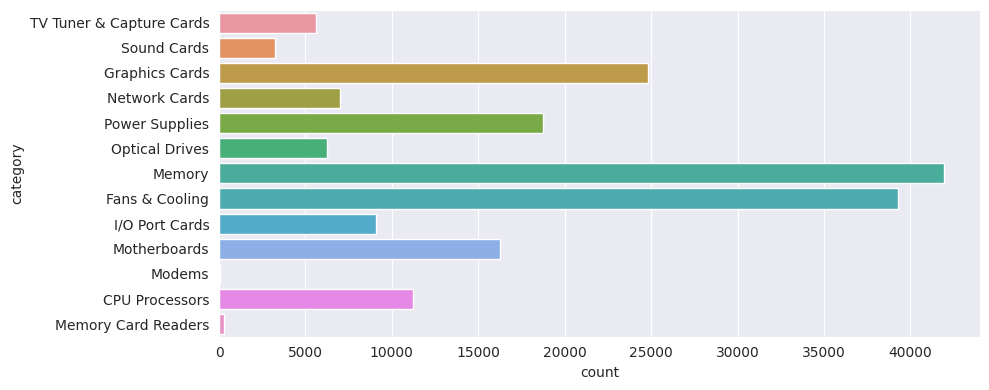

In [7]:
fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(y=data_df["category"].astype("string"))
fig.tight_layout()

### Top 5 brand per Category

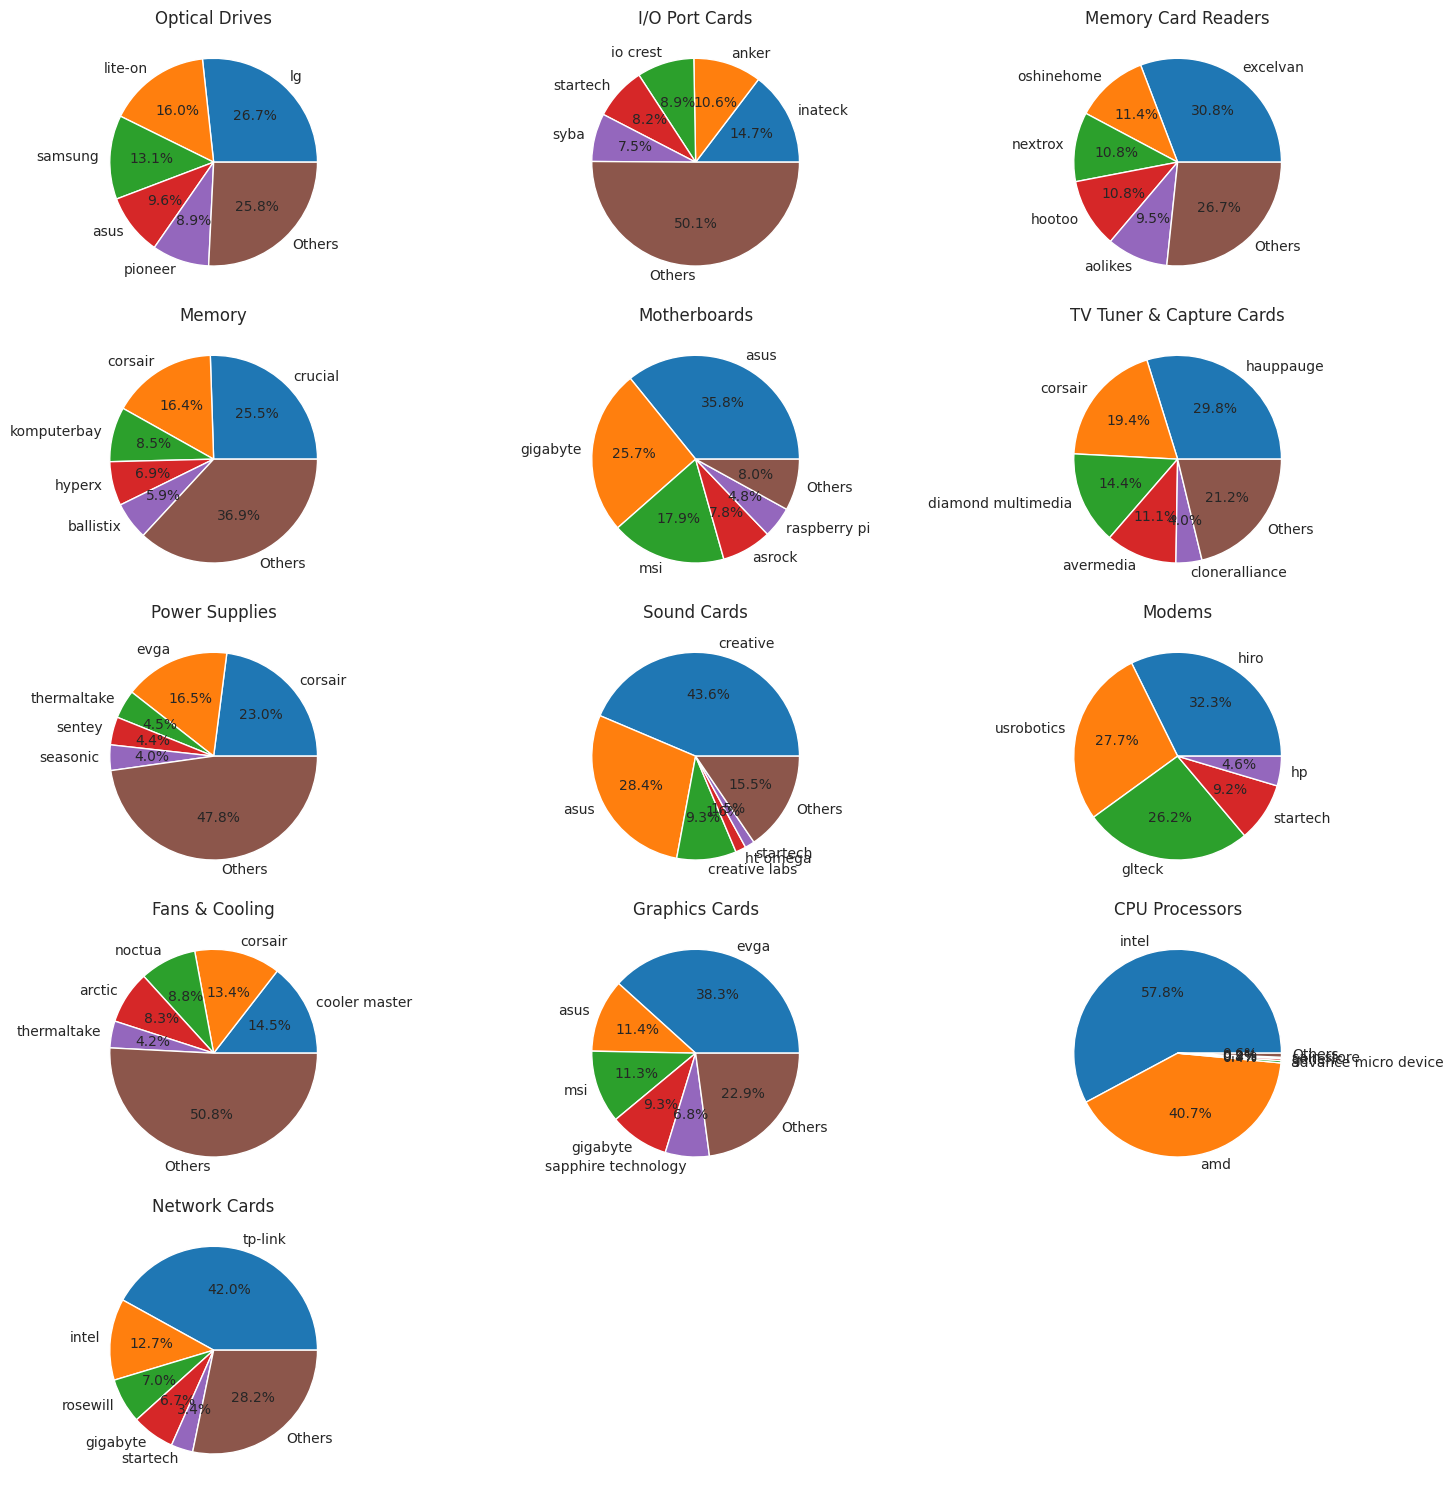

In [11]:
categories = set(data_df["category"])
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
axes = axes.flatten()

for i, cat in enumerate(categories):
    z = data_df.loc[data_df["category"] == cat]["brand"]
    data = pd.DataFrame(
        Counter(z.tolist()).most_common(), columns=["brand", "count"]
    ).reset_index(drop=True)

    if len(data) > 5:
        others = pd.DataFrame(
            data={"brand": ["Others"], "count": [data["count"][5:].sum()]}
        )

        data = pd.concat([data[:5], others])

    data.set_index("brand", inplace=True)

    data.plot(
        y="count",
        x=data.index.values,
        kind="pie",
        legend=False,
        autopct="%1.1f%%",
        ax=axes[i],
    )

    axes[i].set_title(cat)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.tight_layout()

# Review Time Series

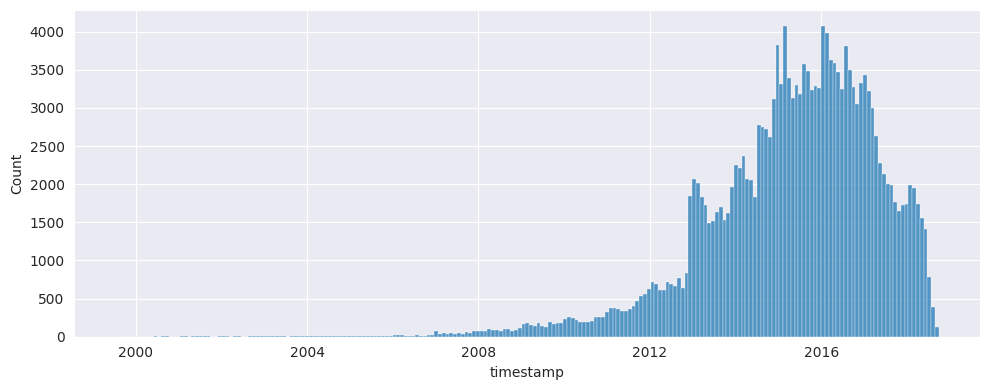

In [12]:
# number of reviews over time of the brand X

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(data_df["timestamp"], ax=ax)
fig.tight_layout()

# Review Text and Summary

### Summary

In [13]:
data_df["summary"].head(20)

0                                        works well
1                                Cheap and it works
2                                        Five Stars
3                  Saves that precious VHS material
4                            customer support sucks
5                         works but needs a fast pc
6     Easy to Use, Almost everything you could want
7                                           Bathtub
8                      Good low-end, no-hassle card
9              Ok for the price and basic functions
10                               Ordered by mistake
11                             Bad out of box board
12                         Does not work for Dos :(
13                     An effective basic soundcard
14                                        good card
15                                             WOW!
16                                Works In Old PC's
17                                HOLY SCHNIKEYS!!!
18                                           Speedy
19          

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


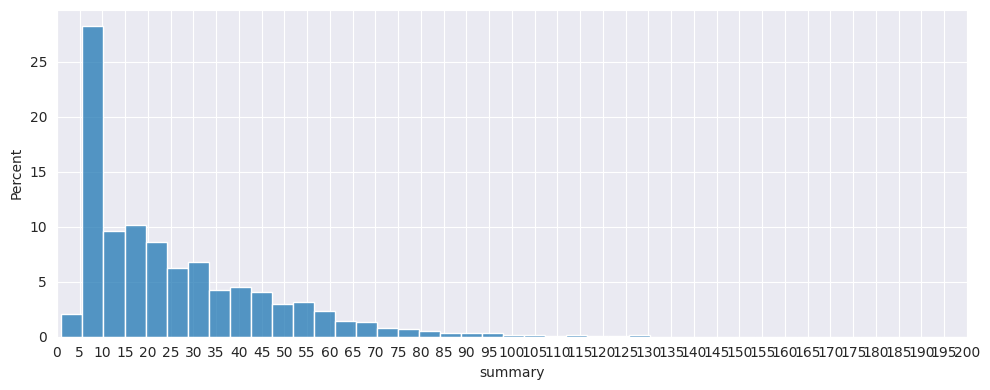

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim([0, 200])
ax.set_xticks(range(0, 205, 5))
sns.histplot(x=data_df["summary"].str.len(), stat="percent", bins=50, ax=ax)
fig.tight_layout()

In [15]:
mean_length = np.round(np.mean(data_df["summary"].str.len()))
print("mean summary length:", mean_length, "characters")

data_df[data_df["summary"].str.len() == mean_length]["summary"].head(30)

mean summary length: 26.0 characters


30      It Works with Windows XP!!
37      ICS function will not work
257     You can flip the direction
271     Easy fix for extra cooling
272     Suprisingly great air flow
275     Great product, Great Price
301     Somewhat noisy, but works.
387     StarTech 250W Power Supply
410     Strong, cheap, functional.
711     Decent range for the price
731     Old as heck, but it works.
756     Fantastic with Windows XP!
948     A fan of this purchase <.<
960     Brainlessly simple install
1052    It worked and did the job!
1256    Does what it's supposed to
1264    Not what I was looking for
1401    Wrong brand and defective.
1410    Just an OK cheap 80mm fan.
1468    good value, GREAT product!
1479    Exactly what my PC needed!
1490    Good Product for the price
1550    very worthwhile investment
1558    BSOD - You've Been WARNED!
1571    Perfect for my home studio
1607    Not reliable unfortunately
1610    Great addition to slow PC.
1611    PC270 184 pin 512MB memory
1638    Software cou

In [16]:
# top 3 most common summary length
len10 = set(data_df[data_df["summary"].str.len() == 10]["summary"].head(20))
len11 = set(data_df[data_df["summary"].str.len() == 11]["summary"].head(20))
len9 = set(data_df[data_df["summary"].str.len() == 9]["summary"].head(20))

print(len10, "\n\n", len11, "\n\n", len9)

{'old memory', 'Five Stars', 'Works well', 'I love it!', 'its memory', 'Four Stars', 'works well', 'Clockwork!'} 

 {'No problems', 'Outstanding', 'Works good.', 'Think twice', 'Great RAM !', 'Works Great', 'much better', 'Works great', 'pretty good', 'A fair card', 'Worked fine', 'Fanless Fan', 'Three Stars', 'Very noisy.', 'BAD. AVOID.', 'cool man !!', 'works great', 'Good Memory'} 

 {'Great fan', 'Beautiful', "Don't buy", 'Great fx.', 'High flow', 'Great Fan', 'good card', 'Good Deal', 'Excellent', 'FANTASTIC', "it's okay", 'No workie', 'Two Stars'}


### Text

In [17]:
data_df["text"].head(20)

0     The EZGrabber2 works well but it's software is...
1     I got this because it was pretty decently pric...
2                                         it works fine
3     This works as advertised and has allowed me to...
4     I bought this item when I was running windows ...
5     I bought it to create dvds from home vhs video...
6     This sound card doesn't reproduce MP3 or WAV f...
7     Essentially, this is the entry-level, 16-bit a...
8     This is a basic sound card.  Nothing fancy.  T...
9     This is a basic low-end sound card. It puts ou...
10    Ordered these by mistake. My computer didn't n...
11    I installed per instructions, beign always gro...
12    This pci card works but unfortunatly i needed ...
13    I keep a lot of computer equipment at home, du...
14    The Voodoo 3 is a great card that replaces bot...
15    This card is so fast and really high resolutio...
16    This is a really old card that I bought becaus...
17    I was a bit skeptical when I put my money 

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


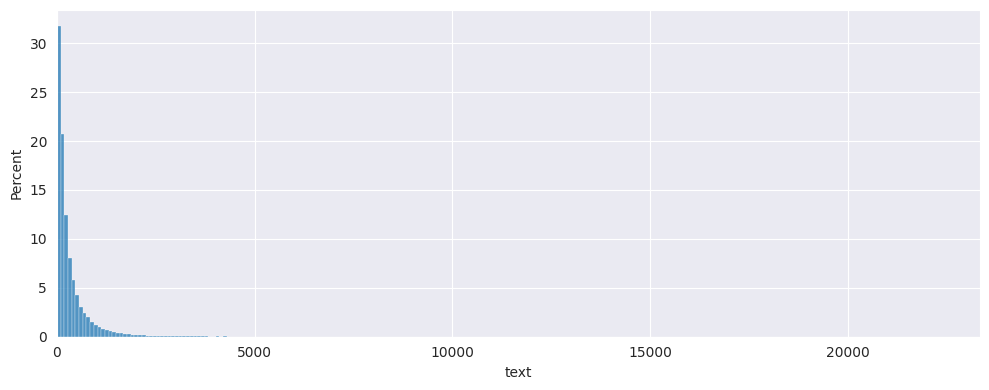

In [18]:
text_lengths = data_df["text"].str.len()

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(text_lengths, stat="percent", bins=250, ax=ax)
ax.set_xlim([0, np.max(text_lengths)])
fig.tight_layout()

In [19]:
mean_length = np.round(np.mean(text_lengths))
print("mean text length:", mean_length, "characters")

data_df[text_lengths == mean_length]["text"].head(10)

mean text length: 346.0 characters


580     Took hours to install.  Tech support does not ...
1279    I did not have any problems with this product ...
1774    I have been evaluating MPEG-2 Encoder cards fo...
2339    Used this in a Dell Studio XPS 9100 case. With...
2723    Runs fine...worked fine ...had a problem intal...
3618    Product sounds exactly like a hair dryer on hi...
3851    This recorder installed every easily and worke...
5712    My onboard USB is 'finicky', sometimes works, ...
7059    I got the package earlier than the estimated d...
7184    1g was already in my laptop. So I thought that...
Name: text, dtype: string

In [20]:
# top 3 most common text length
len9 = set(data_df[text_lengths == 9]["text"].head(10))
len12 = set(data_df[text_lengths == 12]["text"].head(10))
len11 = set(data_df[text_lengths == 11]["text"].head(10))

print(len9, "\n\n", len12, "\n\n", len11)

{'I like it', 'thank you', 'It is ok.', 'excellent', 'expensive', 'Excellent', "as spec'd"} 

 {'Does The Job', 'works  great', 'as described', 'worked great', 'good for diy', 'Good Product', 'As described', 'works great.', 'nice product'} 

 {'didnot work', 'worked well', 'Worked good', 'Works great', 'Worked fine', 'works great', 'Did the job'}


### SUMMARY + TEXT

In [21]:
summary_text = []
for i, row in data_df.iterrows():
    end_line = ".\n"
    if row["summary"].endswith("."):
        end_line = "\n"
    summary_text.append(row["summary"] + end_line + row["text"])
data_df["summary+text"] = summary_text

for i in range(3):
    print(data_df["summary+text"][i], "\n")

works well.
The EZGrabber2 works well but it's software is a little lack luster. I have software installed on my computer that works properly with my night vision so the EZgrabber works well to do what I needed. 

Cheap and it works.
I got this because it was pretty decently priced, honestly though seeing how some of the other video capture devices out there were upwards of $60 I wasn't expecting much.  When I got, I was rather surprised how well it worked.  While it's plug 'n play, I decided to forgo the install CD and just downloaded the drivers directly from the manufacturer's website.  While the video is decent quality, it still retains some grainyness after burning the video to a DVD, the quality of the original played on a VCR is still better quality than what you capture and burn to a DVD.  That being said, it's not all that bad, really.  But since I only needed to copy a few home videos that we made from an old VHS-C camcorder it wasn't really worth it.

I found that the best w

# Overall

<AxesSubplot: ylabel='overall'>

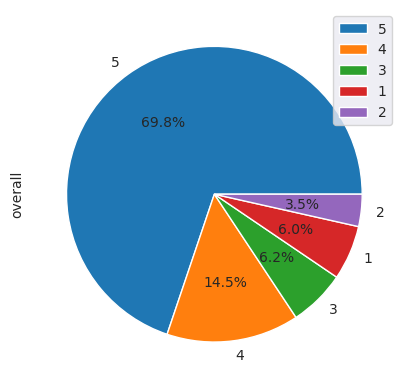

In [22]:
# number by starts
data_df["overall"].value_counts(normalize=True).plot(
    kind="pie", legend=True, autopct="%1.1f%%"
)

<AxesSubplot: ylabel='overall'>

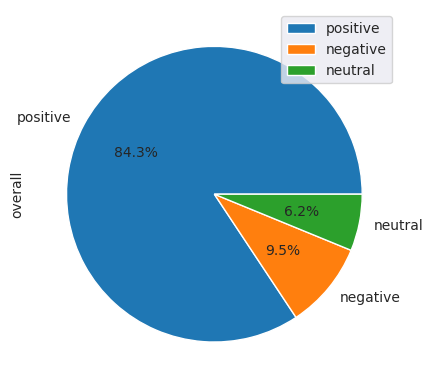

In [23]:
# ground truth polarity
polarity_overall = data_df["overall"].parallel_apply(
    lambda o: "positive" if o > 3 else ("neutral" if o == 3 else "negative")
)
polarity_overall.value_counts(normalize=True).plot(
    kind="pie", legend=True, autopct="%1.1f%%"
)

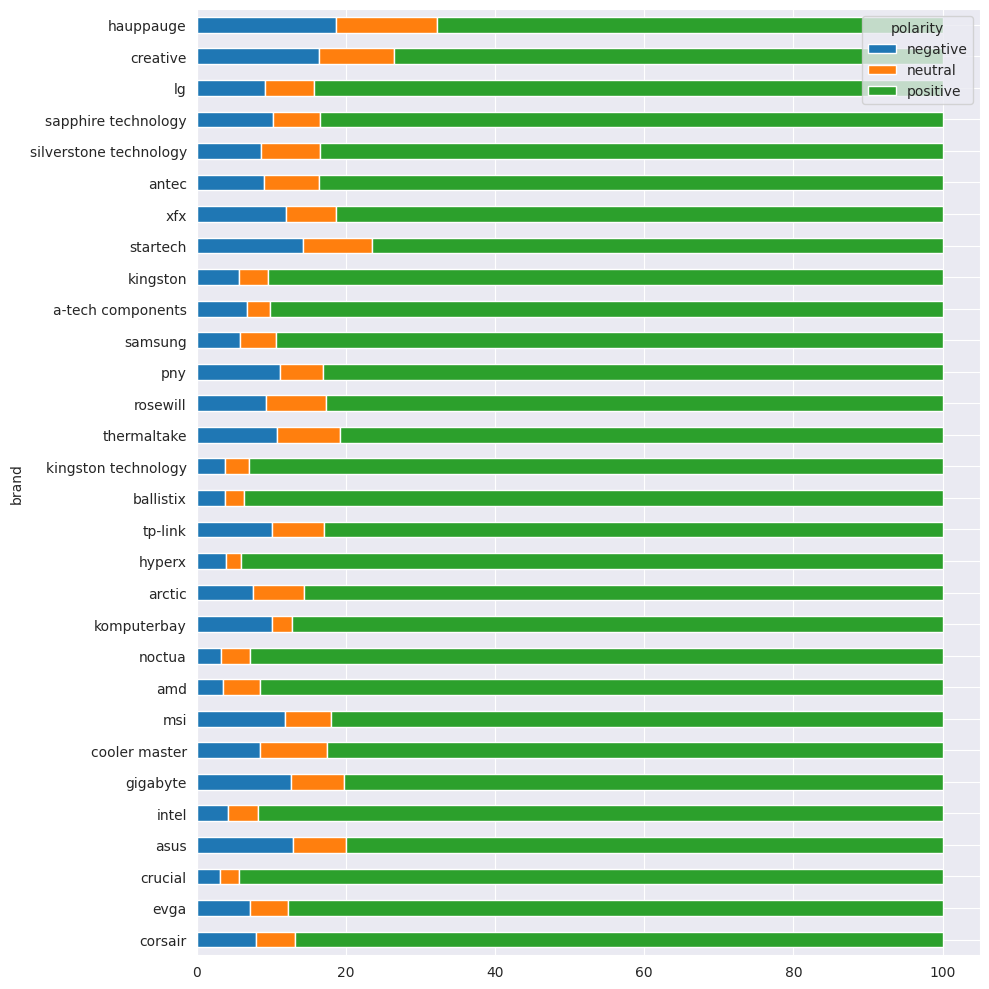

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

data = pd.DataFrame(Counter(data_df["brand"]).most_common(30))

data = data_df.loc[data_df["brand"].isin(set(data[0]))].copy()
data["polarity_overall"] = polarity_overall
x = (
    data[["brand", "polarity_overall"]]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index(name="count")
)
x = x.pivot(columns="polarity", index="brand", values="count")

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

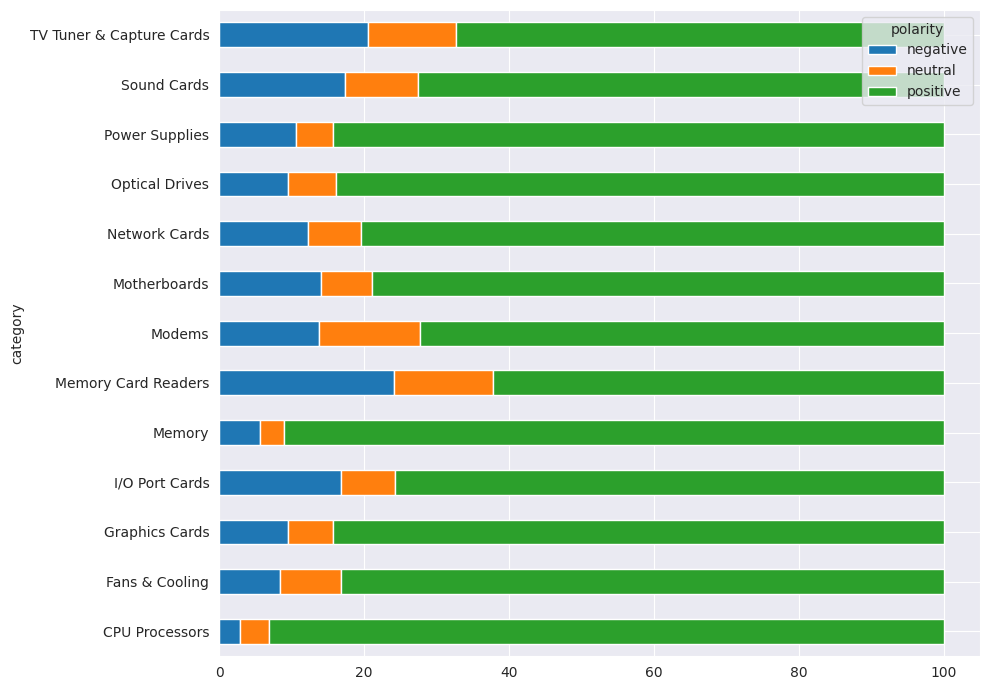

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))

data_df["polarity_overall"] = polarity_overall
x = (
    data_df.groupby("category")["polarity_overall"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="polarity_overall")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

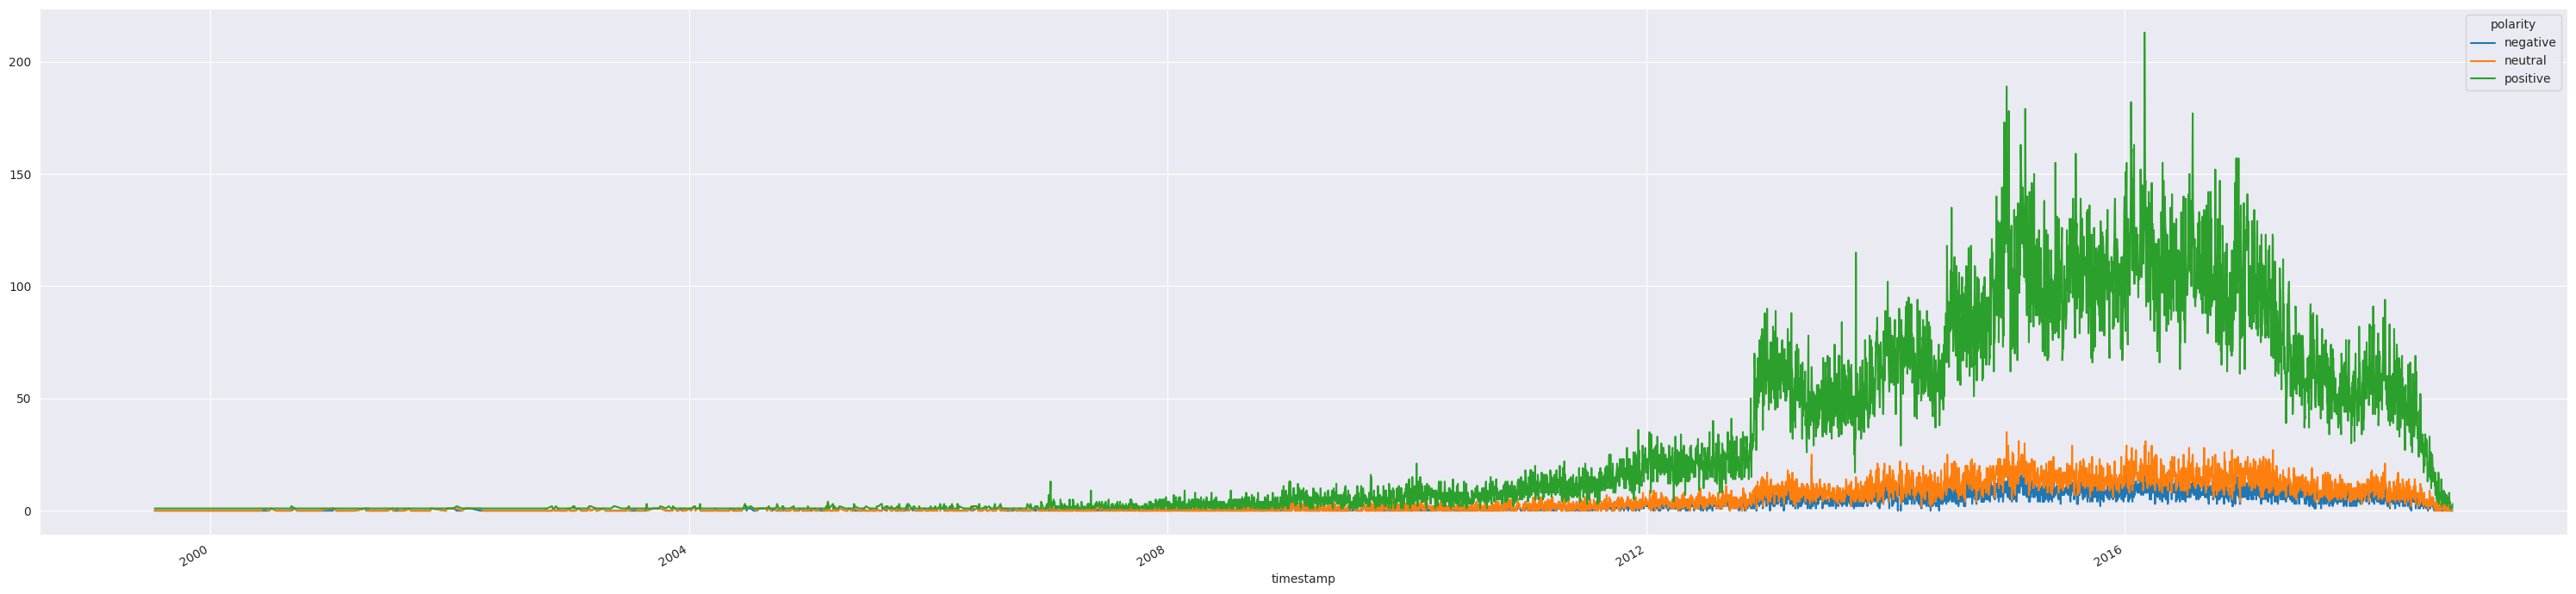

In [26]:
# Overall over time

fig, ax = plt.subplots(figsize=(30, 7))
plt.xticks(rotation=90)

x = (
    data_df.groupby("timestamp")["polarity_overall"]
    .value_counts()
    .rename_axis(["timestamp", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="timestamp", values="polarity_overall")
)
x.reset_index(inplace=True)

x.plot(x="timestamp", kind="line", stacked=True, ax=ax)
fig.tight_layout()

# Vote

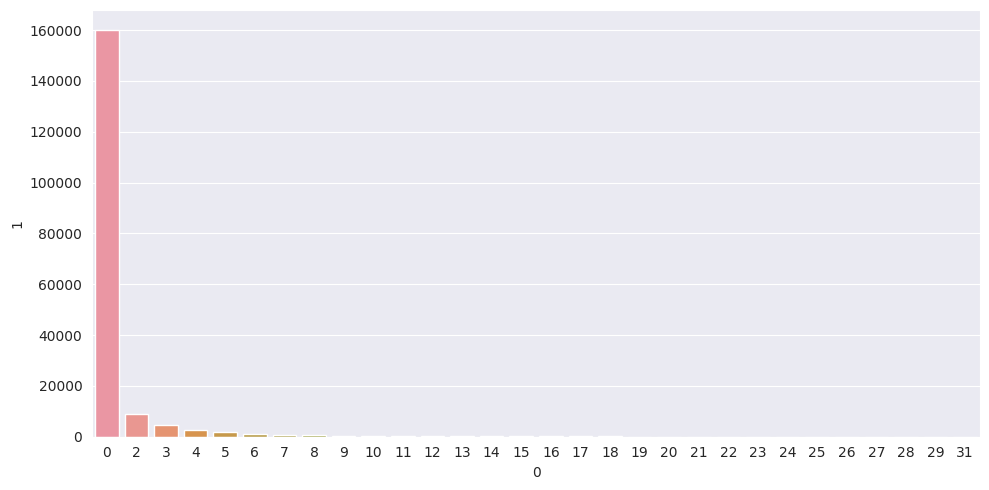

In [27]:
# count of helpful vote number

data = pd.DataFrame(Counter(data_df["vote"].tolist()).most_common(30))
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=data[0], y=data[1], ax=ax)
fig.tight_layout()

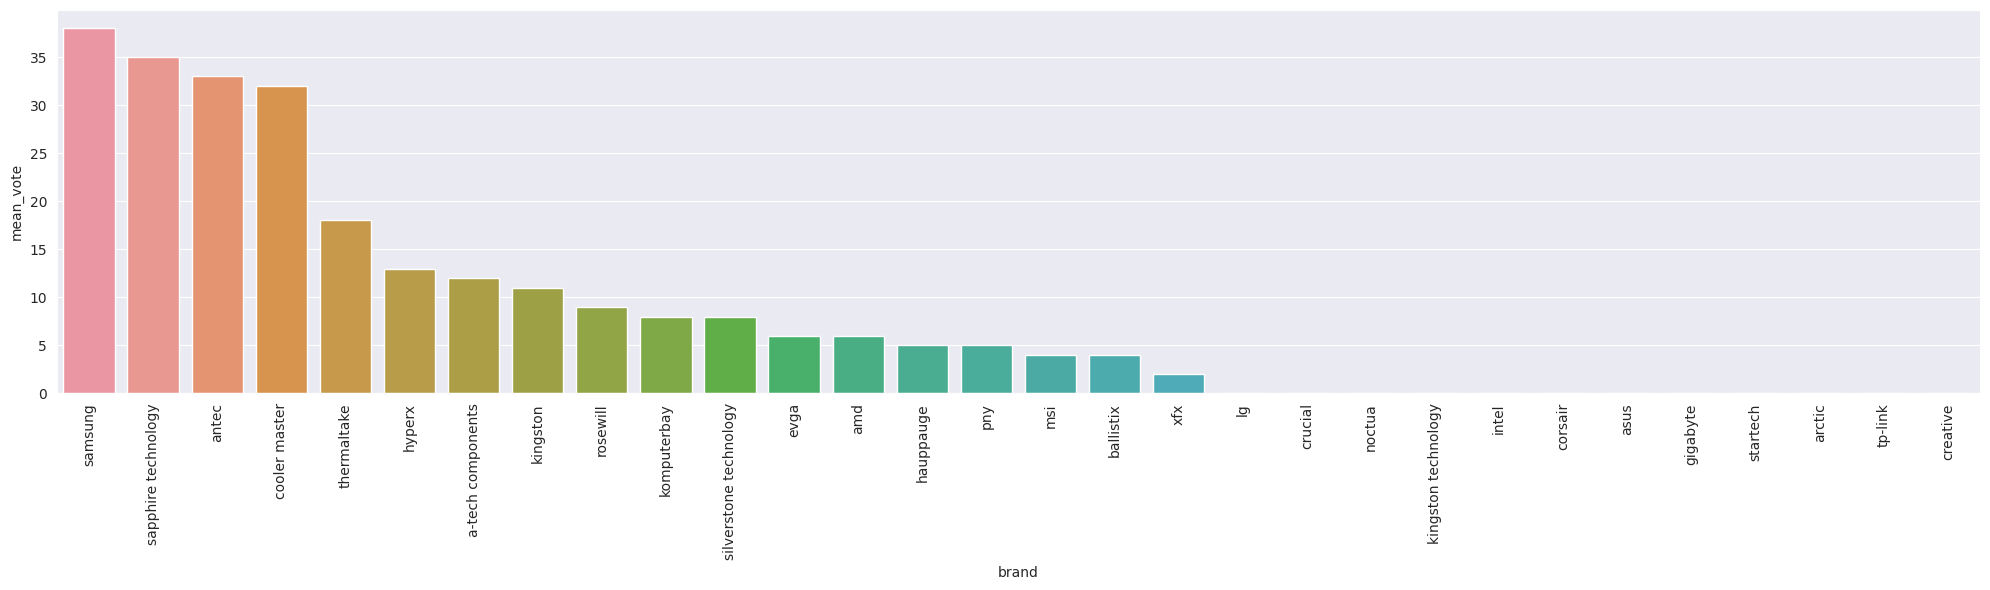

In [28]:
# mean number of util vote for brand

df = data_df.copy()
c = pd.DataFrame(Counter(list(df["brand"])).most_common(30))
df["brand"] = c[0]
df = df.groupby(["brand"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(
    x=df["brand"],
    y=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).brand,
)
plt.xticks(rotation=90)
fig.tight_layout()

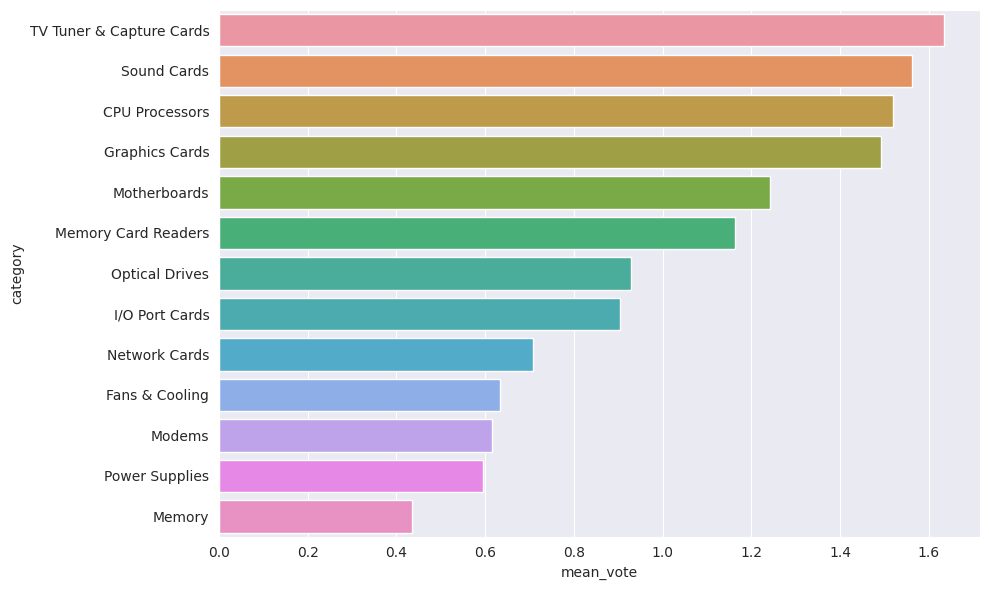

In [29]:
# mean number of util vote for category

df = data_df.copy()
df = df.groupby(["category"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    y=df["category"],
    x=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).category,
)
fig.tight_layout()